In [21]:
%autoreload 2
%matplotlib inline

from pymongo import MongoClient
import pymongo
import sys, os, re
import json
from urllib.parse import urlparse
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import config
from utils import plot, url_utils, plotly_utils

db = MongoClient(config.MONGO_HOSTNAME).web_decay

## CDF of #urls broken across year
- Broken: non 200 status code

2019
2014
2009
2004
1999


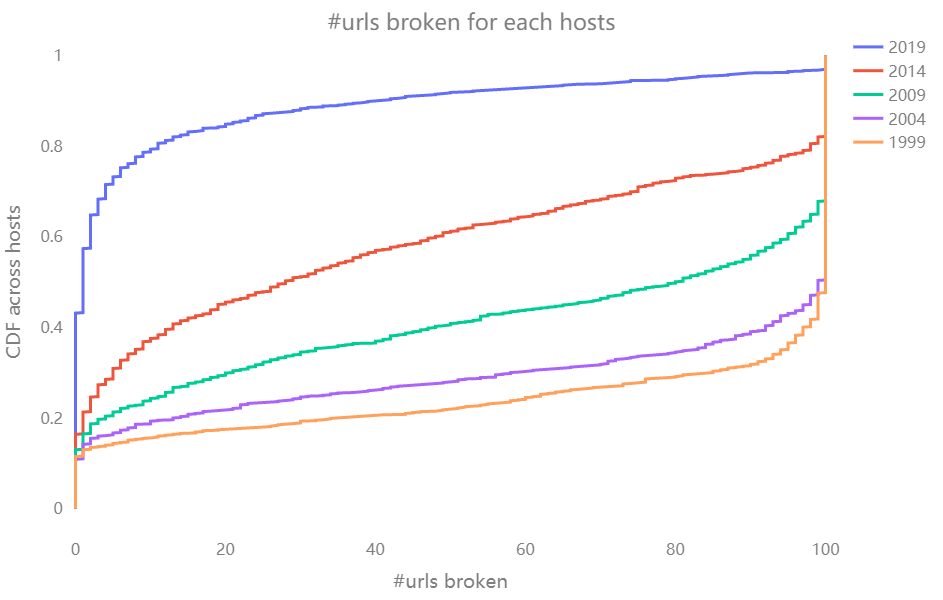

In [84]:
years = [1999, 2004, 2009, 2014, 2019]
df = pd.DataFrame()
for year in reversed(years):
    print(year)
    missing_count = []
    hosts = db.url_status_implicit_broken.aggregate([
        {"$match": {"year": year}},
        {"$group": {"_id": "$hostname"}}
    ])
    for host in hosts:
        count = db.url_status_implicit_broken.count_documents({"year": year, "hostname": host['_id'], "status": re.compile('^[23]')})
        missing_count.append(100 - count)
    df[year] = missing_count
plotly_utils.plot_CDF(df, xtitle="#urls broken", ytitle="CDF across hosts", title="#urls broken for each hosts")

## #status for urls share the same path
- Each path has at least 3 urls

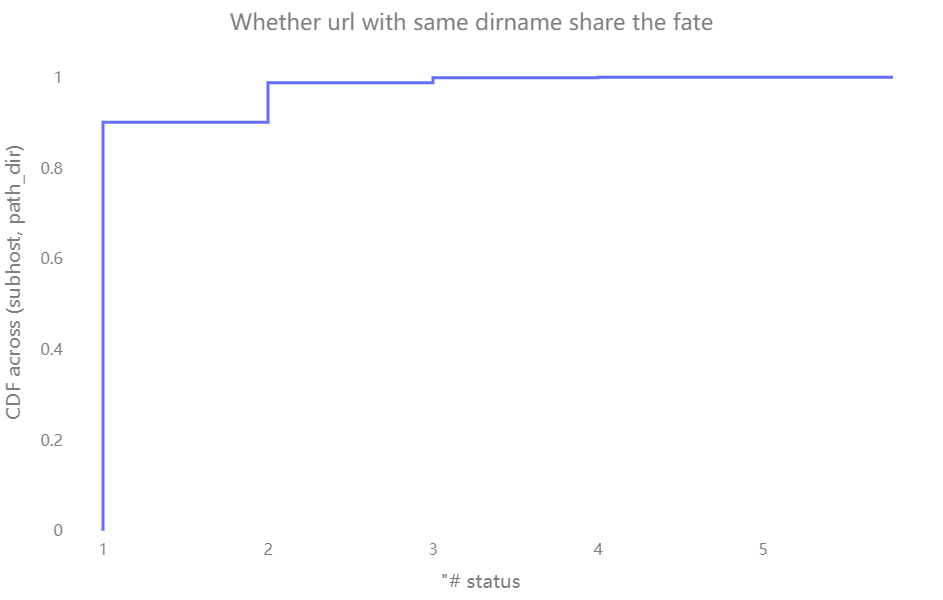

In [87]:
fate = defaultdict(dict)
hosts = db.url_status_implicit_broken.aggregate([
    {"$group": {"_id": "$hostname"}}
])
for i, host in enumerate(list(hosts)):
    host_fate = defaultdict(list)
    urls = db.url_status_implicit_broken.find({"hostname": host['_id']})
    for url in urls:
        up = urlparse(url['url'])
        subhost, path, query = up.netloc, up.path, up.query
        if path == '': path = '/'
        dirname = os.path.dirname(path)
        host_fate["{}|{}".format(subhost, dirname)].append(url_utils.status_categories(url['status'], url['detail']))
    dir_count = {}
    for dirname, statuss in host_fate.items():
        if len(statuss) >= 3:
            dir_count[dirname] = set(statuss)
    fate[host['_id']] = dir_count
fate_df, fate_count = pd.DataFrame({'num_status': []}), defaultdict(int)
for hostname, dir_count in fate.items():
    for dirname, statuss in dir_count.items():
        fate_df = fate_df.append({'num_status': len(statuss)}, ignore_index=True)
        if len(statuss) > 1:
            fate_count[tuple(sorted(list(statuss)))] += 1
fate = {h: {d: list(s) for d, s in ds.items() if len(s) > 1} for h, ds in fate.items()}
fate = {h: ds for h, ds in fate.items() if len(ds) > 0}
# json.dump(fate, open('fate.json', 'w+'))
fate_count = [list(k) + [v] for k, v in fate_count.items()]
fate_count.sort(key=lambda x: x[-1], reverse=True)
json.dump(fate_count, open('fate_count.json', 'w+') )
plotly_utils.plot_CDF(fate_df, xtitle='"# status', ytitle='CDF across (subhost, path_dir)',\
                      title='Whether url with same dirname share the fate')

#### Some high multi-status compinations:

In [ ]:
[
  ["4/5xx", "no redirection", 721],
  ["4/5xx", "non-home redirection", 395],
  ["no redirection", "non-home redirection", 295],
  ["4/5xx", "OtherError_Ping failure", 128],
  ["4/5xx", "no redirection", "non-home redirection", 127],
  ["OtherError_80_open_443_open", "no redirection", 96],
  ["OtherError_Ping failure", "no redirection", 89]
]